# Neural Network - MultiLayer Perceptron (MLP)

In [1]:
import sys
import pandas as pd
import time
import datetime
import random
from matplotlib import pyplot as plt

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE 

import numpy as np
from numpy import loadtxt
from numpy.random import seed

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
#from sklearn.pipeline import # Pipeline # make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Data preperation

In [2]:
# function to reset all RNG's to seed 23
def reset_random_seeds():
   tf.random.set_seed(23) # tensorflow's seed
   np.random.seed(23) # numpy's seed
   random.seed(23) # python's seed

In [3]:
# import data
data = pd.read_csv (r'bank-additional-full.csv', sep = ';', engine= 'python')
#data = data.head(1000)
length = data.shape[0]
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# select variables
cats_to_use = ['age', 'default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed', 'y']
data = data[cats_to_use]

# 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
#       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
#       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
#       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'

In [5]:
# save lists of categorical and numerical variables
cat_cols = ['default', 'contact', 'month', 'poutcome', 'y']
num_cols = ['age', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']

# create column transformer to 1 one-hot-encode cat vars and 2 noralise num vars
ct = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_cols), # drop first column (reference)
    (StandardScaler(), num_cols),
)

# transform base table (pandas df -> numpy array)
base = ct.fit_transform(data)

# convert base table to p.df for ease of use (numpy array -> pandas df)
base_temp = pd.DataFrame(base, columns=ct.get_feature_names_out().tolist())
base_temp

,onehotencoder__default_unknown,onehotencoder__default_yes,onehotencoder__contact_telephone,onehotencoder__month_aug,onehotencoder__month_dec,onehotencoder__month_jul,onehotencoder__month_jun,onehotencoder__month_mar,onehotencoder__month_may,onehotencoder__month_nov,onehotencoder__month_oct,onehotencoder__month_sep,onehotencoder__poutcome_nonexistent,onehotencoder__poutcome_success,onehotencoder__y_yes,standardscaler__age,standardscaler__previous,standardscaler__emp.var.rate,standardscaler__euribor3m,standardscaler__nr.employed
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.533034,-0.349494,0.648092,0.712460,0.331680
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.628993,-0.349494,0.648092,0.712460,0.331680
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.290186,-0.349494,0.648092,0.712460,0.331680
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.002309,-0.349494,0.648092,0.712460,0.331680
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.533034,-0.349494,0.648092,0.712460,0.331680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.164336,-0.349494,-0.752343,-1.495186,-2.815697
41184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.573445,-0.349494,-0.752343,-1.495186,-2.815697
41185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.533034,-0.349494,-0.752343,-1.495186,-2.815697
41186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.381527,-0.349494,-0.752343,-1.495186,-2.815697


In [6]:
# check list of column names in base table
base_temp.columns.tolist()

['onehotencoder__default_unknown',
 'onehotencoder__default_yes',
 'onehotencoder__contact_telephone',
 'onehotencoder__month_aug',
 'onehotencoder__month_dec',
 'onehotencoder__month_jul',
 'onehotencoder__month_jun',
 'onehotencoder__month_mar',
 'onehotencoder__month_may',
 'onehotencoder__month_nov',
 'onehotencoder__month_oct',
 'onehotencoder__month_sep',
 'onehotencoder__poutcome_nonexistent',
 'onehotencoder__poutcome_success',
 'onehotencoder__y_yes',
 'standardscaler__age',
 'standardscaler__previous',
 'standardscaler__emp.var.rate',
 'standardscaler__euribor3m',
 'standardscaler__nr.employed']

In [7]:
# seperate base table into X and y and convert to numpy array (base pandas df -> y numpy array + X numpy array)
y = base_temp['onehotencoder__y_yes'].values
X = base_temp.drop(columns=['onehotencoder__y_yes']).values

# save and check dimensions of X 
(X_length, X_vars) = X.shape
X_length, X_vars

(41188, 19)

In [8]:
# create train/test split
train_features, test_features, train_targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=23)

## The model
First make a function to create a complete keras model. These models can later be wrapped by a sklearn compatible classifier to be able to use sklearns functions on the model.

In [9]:
# function returns keras NN
def create_model(hiddenLayerOne=10, learnRate=0.01):
    # reset RNG's
    reset_random_seeds()
    
    # define model (input layer (X_vars-d) > hidden layer (12-d) > output layer (1-d))
    model = tf.keras.models.Sequential()
    model.add(Dense(hiddenLayerOne, input_dim=X_vars, activation='sigmoid')) # input + hidden layer: 12 nodes + relu (TUNE #NODES!)
    model.add(Dense(1, activation='sigmoid')) # output layer: 1 node + sigmoid

    # compile model (Adam performs well (source?), AUC for comparison)
    model.compile(
        loss='binary_crossentropy', 
        optimizer=Adam(learning_rate=learnRate), 
        metrics=['accuracy']) # tf.keras.metrics.AUC()
    
    # return compiled model
    return model

### Hyperparameter tuning using grid search, k-fold cv and undersampling
This algorithm runs some model configurations on the training dataset (80\% of full dataset). It uses cross validation to get better accuracy estimates. Inside each fold, the training data is undersampled but the validation data is not. This results in the most accurate hyperparameter process. The optimal hyperparameter combination is printed at the end.

Running time on full dataset, with 192 grid points and using 1-fold cross validation: 7.5 hrs

In [10]:
# for model timing
time.ctime()

'Wed Apr  6 17:45:21 2022'

In [11]:
# define hyperparameter search space
hiddenLayerOne = [3, 6, 10, 15]
learnRate = [1e-1, 1e-2, 1e-3]
batchSize = [16, 32, 64, 128]
epochs = [10, 30, 50, 80]

# create dictionary from search space
grid = dict(
    kerasclassifier__hiddenLayerOne=hiddenLayerOne,
    kerasclassifier__learnRate=learnRate,
    kerasclassifier__batch_size=batchSize,
    kerasclassifier__epochs=epochs
)

# create 10-fold cross validation generator
cv = KFold(n_splits=10)

# create imbalanced learn pipeline
imba_pipeline = make_pipeline(NearMiss(version=1), KerasClassifier(build_fn=create_model, verbose=0))

# create grid search model with 10-fold cv and start tuning process
model_grid = GridSearchCV(estimator=imba_pipeline, param_grid=grid, n_jobs=1, cv=cv, verbose=5, scoring='roc_auc')
grid_res = model_grid.fit(train_features, train_targets)

# summarise grid search info
bestScore = grid_res.best_score_
bestParams = grid_res.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
    bestParams))

# for model timing
time.ctime()

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Instructions for updating:
Please use `model.predict()` instead.
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.703 total time=   6.5s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.748 total time=   4.4s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.754 total time=   5.5s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.725 total time=   5.6s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.695 total time=   4.3s
[CV 6

[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.706 total time=   5.0s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.744 total time=   4.6s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.703 total time=   5.0s
[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.763 total time=   4.9s
[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.704 total time=   5.6s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__lea

[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.732 total time=  14.0s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.727 total time=  14.4s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.695 total time=  15.7s
[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.716 total time=  16.6s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.737 total time=  15.9s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__lea

[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.708 total time=  34.1s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.719 total time=  33.9s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.758 total time=  30.2s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.751 total time=  31.2s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.744 total time=  34.1s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier_

[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.732 total time=  37.0s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.707 total time=  36.8s
[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.743 total time=  33.3s
[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.691 total time=  33.8s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.709 total time=  35.5s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__l

[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.748 total time=  29.5s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.727 total time=  31.1s
[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.727 total time=  29.0s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.750 total time=  25.7s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.716 total time=  27.6s
[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclass

[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.739 total time=  33.7s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.735 total time=  32.4s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.727 total time=  34.6s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.700 total time=  34.8s
[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.706 total time=  37.6s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__lear

[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.768 total time=  34.3s
[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.712 total time=  45.1s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.698 total time=  39.2s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.739 total time=  37.5s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.716 total time=  37.4s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier

[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.709 total time= 1.0min
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.734 total time=  28.5s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.708 total time=  18.8s
[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.758 total time=  17.7s
[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.710 total time=  22.3s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__lea

[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.722 total time=  20.7s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.724 total time=  20.5s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.684 total time=  24.9s
[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.688 total time=  21.9s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.732 total time=  21.9s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__lea

[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.684 total time=  19.7s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.718 total time=  20.2s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.764 total time=  18.4s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.749 total time=  25.7s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.740 total time=  19.9s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclass

[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.731 total time=   3.0s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.699 total time=   6.4s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.757 total time=   3.9s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.707 total time=   3.3s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.718 total time=   3.5s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRa

[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.745 total time=   3.3s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.727 total time=   3.2s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.729 total time=   3.1s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.747 total time=   3.0s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.713 total time=   3.2s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclass

[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.715 total time=   4.9s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.755 total time=   4.8s
[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.752 total time=   5.2s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.746 total time=   4.8s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.718 total time=   5.1s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__lear

[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.763 total time=  15.3s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.712 total time=  14.6s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.714 total time=  14.4s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.743 total time=  15.2s
[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.720 total time=  18.6s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__

[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.698 total time=  19.2s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.733 total time=  14.7s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.694 total time=  17.7s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.757 total time=  15.9s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.702 total time=  15.7s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifie

[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.731 total time=  27.9s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.723 total time=  27.5s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.691 total time=  36.3s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.697 total time=  29.8s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.734 total time=  28.5s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate

[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.700 total time=  29.6s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.722 total time=  31.5s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.761 total time=  32.9s
[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.751 total time=  29.8s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.745 total time=  28.9s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclass

[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.727 total time=  18.2s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.708 total time=  16.8s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.748 total time=  17.3s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.697 total time=  18.3s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.707 total time=  17.3s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRa

[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.723 total time=  20.1s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.720 total time=  18.0s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.750 total time=  20.6s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.715 total time=  21.6s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.766 total time=  23.5s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier

[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.738 total time=  22.9s
[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.721 total time=  19.9s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.710 total time=  19.8s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.690 total time=  17.6s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.696 total time=  20.3s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier

[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.767 total time=   4.2s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.725 total time=   4.8s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.715 total time=   4.3s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.756 total time=   3.5s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.742 total time=   3.7s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__lear

[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.746 total time=   5.2s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.712 total time=   4.9s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.764 total time=   5.6s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.707 total time=   4.5s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.722 total time=   4.2s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifi

[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.729 total time=   5.8s
[CV 5/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.719 total time=   6.0s
[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.697 total time=   5.8s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.732 total time=   5.6s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.703 total time=   5.5s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate

[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.759 total time=   6.2s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.750 total time=   5.7s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.744 total time=   6.0s
[CV 5/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.724 total time=   4.7s
[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.727 total time=   5.0s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier_

[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.739 total time=   5.6s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.691 total time=   4.7s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.715 total time=   5.0s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.752 total time=   5.2s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.741 total time=   5.7s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier_

[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.725 total time=   7.9s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.748 total time=   7.9s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.712 total time=   7.6s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.761 total time=   7.9s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.711 total time=   8.2s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier

[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.724 total time=   8.5s
[CV 5/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.700 total time=   8.0s
[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.705 total time=   7.7s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.732 total time=   8.9s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.705 total time=   8.4s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier

[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.698 total time=  13.3s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.757 total time=  11.1s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.736 total time=  12.1s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.715 total time=  10.4s
[CV 5/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.705 total time=  10.7s
[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate

[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.758 total time=  10.7s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.695 total time=   9.0s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.721 total time=  13.2s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.760 total time=  12.1s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.751 total time=  10.7s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__

[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.691 total time=   9.8s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.730 total time=   9.9s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.677 total time=   9.2s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.738 total time=   9.8s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.687 total time=   9.5s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__le

[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.760 total time=   5.7s
[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.754 total time=   3.5s
[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.742 total time=   4.0s
[CV 6/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.746 total time=   3.6s
[CV 7/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.759 total time=   3.7s
[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclass

[CV 10/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.697 total time=   3.9s
[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.719 total time=   3.4s
[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.762 total time=   3.2s
[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.748 total time=   6.2s
[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.744 total time=   4.2s
[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclas

[CV 7/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.757 total time=   3.2s
[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.721 total time=   3.2s
[CV 9/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.771 total time=   3.1s
[CV 10/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.730 total time=   3.1s
[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.719 total time=   3.8s
[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerascl

[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.741 total time=   3.3s
[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.722 total time=   4.6s
[CV 6/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.712 total time=   4.3s
[CV 7/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.744 total time=   4.8s
[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.707 total time=   4.7s
[CV 9/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier

[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.692 total time=   3.4s
[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.742 total time=   3.4s
[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.719 total time=   3.2s
[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.724 total time=   3.2s
[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.705 total time=   3.4s
[CV 6/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifie

[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.712 total time=   3.9s
[CV 9/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.771 total time=   3.5s
[CV 10/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.707 total time=   4.8s
[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.718 total time=   3.9s
[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.758 total time=   3.6s
[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassif

[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.683 total time=   5.5s
[CV 6/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.687 total time=   4.4s
[CV 7/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.724 total time=  13.0s
[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.701 total time=   8.3s
[CV 9/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.747 total time=   9.2s
[CV 10/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifi

[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.760 total time=   6.9s
[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.750 total time=   8.0s
[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.746 total time=   7.1s
[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.725 total time=   9.1s
[CV 6/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.728 total time=   7.1s
[CV 7/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kera

[CV 9/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.746 total time=   9.3s
[CV 10/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.685 total time=  10.9s
[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.712 total time=   9.4s
[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.749 total time=   9.1s
[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.743 total time=  11.0s
[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier_

[CV 6/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.726 total time=   9.1s
[CV 7/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.749 total time=   9.1s
[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.714 total time=  11.0s
[CV 9/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.764 total time=   9.0s
[CV 10/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.713 total time=  12.0s
[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, ker

'Thu Apr  7 01:05:50 2022'

In [10]:
# best hyperparameters
batch_size = 128
epochs = 10
nodes = 6
learn_rate = 0.001

## Undersample training data for further analysis

In [11]:
# underfit training data using nearmiss 1
nm = NearMiss(version = 1)
x_res, y_res = nm.fit_resample(train_features, train_targets)
train_features.shape,x_res.shape

((32950, 19), (7506, 19))

## Overfitting check
Vary amout of epochs over several model runs.

Epoch 1/10
59/59 [==============================] - 0s 1ms/step - loss: 0.6831 - accuracy: 0.5430
Epoch 2/10
59/59 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.7822
Epoch 3/10
59/59 [==============================] - 0s 2ms/step - loss: 0.5700 - accuracy: 0.8028
Epoch 4/10
59/59 [==============================] - 0s 2ms/step - loss: 0.5299 - accuracy: 0.8040
Epoch 5/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4993 - accuracy: 0.8052
Epoch 6/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.8076
Epoch 7/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.8095
Epoch 8/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4488 - accuracy: 0.8104
Epoch 9/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8118
Epoch 10/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.8132
n_estimator: 1, tra

59/59 [==============================] - 0s 1ms/step - loss: 0.6831 - accuracy: 0.5430
Epoch 2/10
59/59 [==============================] - 0s 1ms/step - loss: 0.6195 - accuracy: 0.7822
Epoch 3/10
59/59 [==============================] - 0s 1ms/step - loss: 0.5700 - accuracy: 0.8028
Epoch 4/10
59/59 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.8040
Epoch 5/10
59/59 [==============================] - 0s 1ms/step - loss: 0.4993 - accuracy: 0.8052
Epoch 6/10
59/59 [==============================] - 0s 1ms/step - loss: 0.4768 - accuracy: 0.8076
Epoch 7/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.8095
Epoch 8/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4488 - accuracy: 0.8104
Epoch 9/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8118
Epoch 10/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.8132
n_estimator: 9, train: 0.815, 

59/59 [==============================] - 0s 1ms/step - loss: 0.6831 - accuracy: 0.5430
Epoch 2/10
59/59 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.7822
Epoch 3/10
59/59 [==============================] - 0s 2ms/step - loss: 0.5700 - accuracy: 0.8028
Epoch 4/10
59/59 [==============================] - 0s 2ms/step - loss: 0.5299 - accuracy: 0.8040
Epoch 5/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4993 - accuracy: 0.8052
Epoch 6/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.8076
Epoch 7/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.8095
Epoch 8/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4488 - accuracy: 0.8104
Epoch 9/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8118
Epoch 10/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.8132
n_estimator: 86, train: 0.815,

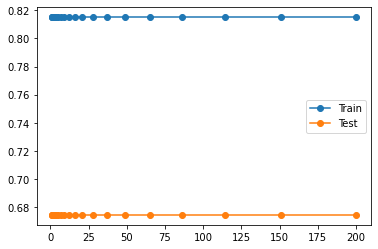

In [14]:
# define lists to collect scores
train_scores, test_scores = list(), list()

# define the estimators to evaluate
values = np.geomspace(1, 200, num=20, dtype=int)
#values = range(1, 200, 20)
for i in values:
    # create and train model on training data
    overfit_model = create_model(hiddenLayerOne=nodes, learnRate=learn_rate)
    overfit_model.fit(x_res, y_res, epochs=epochs, batch_size=batch_size)
    
    # evaluate on the train dataset
    prediction_train = overfit_model.predict_classes(x_res)
    train_auc = roc_auc_score(y_res, prediction_train)
    train_scores.append(train_auc)
    
    # evaluate on the test dataset
    prediction_test = overfit_model.predict_classes(test_features)
    test_auc = roc_auc_score(test_targets, prediction_test)
    test_scores.append(test_auc)
    
    # summarize progress
    print('n_estimator: %.0f, train: %.3f, test: %.3f' % (i, train_auc, test_auc))
# plot of train and test scores vs n_estimator
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

#### Overfitting conclusion:
We can conclude that ~100 epochs results in the highest validation AUC, although the performance gain after 70 epocs is very small. Buy given the relatively short running time of this model, we decide to use 100 epochs in the final model.

## Final Model
Run model using the best hyperparameter combination and 100 eopchs. Compute AUC for model comparison purposes.

Epoch 1/10
59/59 [==============================] - 0s 2ms/step - loss: 0.6831 - accuracy: 0.5430
Epoch 2/10
59/59 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.7822
Epoch 3/10
59/59 [==============================] - 0s 2ms/step - loss: 0.5700 - accuracy: 0.8028
Epoch 4/10
59/59 [==============================] - 0s 2ms/step - loss: 0.5299 - accuracy: 0.8040
Epoch 5/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4993 - accuracy: 0.8052
Epoch 6/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.8076
Epoch 7/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.8095
Epoch 8/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4488 - accuracy: 0.8104
Epoch 9/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8118
Epoch 10/10
59/59 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.8132
Instructions for up

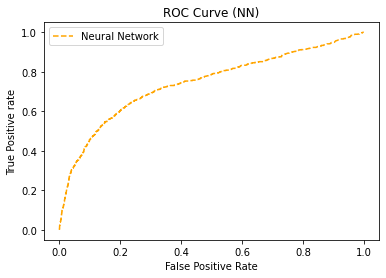

AUC Score: 0.742


In [13]:
# create final model
fin_model = create_model(hiddenLayerOne=nodes, learnRate=learn_rate)

# fit model on the dataset
fin_model.fit(x_res, y_res, epochs=epochs, batch_size=batch_size)

# predict marketing success for test dataset
predictions = fin_model.predict_classes(test_features)
    
# print conf mat and classification report
print("Confusion Matrix:")
print(confusion_matrix(test_targets, predictions))
print("Classification Report")
print(classification_report(test_targets, predictions))

# plot ROC-curve
pred_prob = fin_model.predict(test_features)
fpr, tpr, thresh = roc_curve(test_targets, pred_prob, pos_label=1) #[:,1]
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Neural Network')

# title
plt.title('ROC Curve (NN)')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
    
# AUC Score
auc_score = roc_auc_score(test_targets, pred_prob) #[:,1]
print("AUC Score: " + str(np.round(auc_score , 3)))